# session-based recommendation project
AIFFEL 대전 탐색 노드 17

프로세스는 다음과 같다. (노드의 제시된 순서)
1. 데이터 전처리
2. 미니 배치의 구성
3. 모델 구성
4. 모델 학습
5. 모델 테스트

## 1. 데이터 전처리
- 데이터 불러오기
- 데이터 이해하기
- 데이터 정제하기

### 데이터 불러오기

In [1]:
# 데이터 설명(README)를 읽어 봅니다. 
import os
f = open(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m/README', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

SUMMARY




These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 

made by 6,040 MovieLens users who joined MovieLens in 2000.



USAGE LICENSE




Neither the University of Minnesota nor any of the researchers

involved can guarantee the correctness of the data, its suitability

for any particular purpose, or the validity of results based on the

use of the data set.  The data set may be used for any research

purposes under the following conditions:



     * The user may not state or imply any endorsement from the

       University of Minnesota or the GroupLens Research Group.



     * The user must acknowledge the use of the data set in

       publications resulting from the use of the data set

       (see below for citation information).



     * The user may not redistribute the data without separate

       permission.



     * The user may not use this information for any commercial or

       revenue-bearing purposes without first obtaining permi

In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
# data loading
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    #data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    #data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 3], dtype={0: np.int32, 1: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Time']
    
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Time
31,1,3186,978300019
22,1,1270,978300055
27,1,1721,978300055
37,1,1022,978300055
24,1,2340,978300103
...,...,...,...
1000019,6040,2917,997454429
999988,6040,1921,997454464
1000172,6040,1784,997454464
1000167,6040,161,997454486


In [4]:
# 시간 변환
import datetime, time
times = data["Time"] 
temp_list = [] 
for time in times: 
    #temp_date = dt.datetime.fromtimestamp(time).strftime('%Y-%m-%d %H:%M:%S')
    temp_date = dt.datetime.fromtimestamp(time)
    temp_list.append(temp_date)
#print(temp_list)
data["Time"] = temp_list 
data

,UserId,ItemId,Time
31,1,3186,2001-01-01 07:00:19
22,1,1270,2001-01-01 07:00:55
27,1,1721,2001-01-01 07:00:55
37,1,1022,2001-01-01 07:00:55
24,1,2340,2001-01-01 07:01:43
...,...,...,...
1000019,6040,2917,2001-08-10 23:40:29
999988,6040,1921,2001-08-10 23:41:04
1000172,6040,1784,2001-08-10 23:41:04
1000167,6040,161,2001-08-10 23:41:26


### 데이터 이해하기

In [5]:
# 유저 수 및 아이템 수 확인
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [6]:
# 유저의 사용량 확인
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [7]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [8]:
session_length.min(), session_length.max()

(20, 2314)

In [9]:
session_length.quantile(0.999)

1343.181000000005

In [10]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Time
696969,4169,1268,2000-08-04 05:09:52
697168,4169,2617,2000-08-04 05:09:52
697185,4169,2628,2000-08-04 05:09:52
697219,4169,2653,2000-08-04 05:09:52
697275,4169,423,2000-08-04 05:09:52
...,...,...,...
697882,4169,3754,2002-06-16 05:52:27
695702,4169,1413,2002-06-16 06:03:51
697358,4169,494,2002-06-16 06:16:00
695945,4169,1804,2002-06-16 06:16:23


In [11]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

Duplicate key in file PosixPath('/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 250 ('font.family:  NanumGothic')


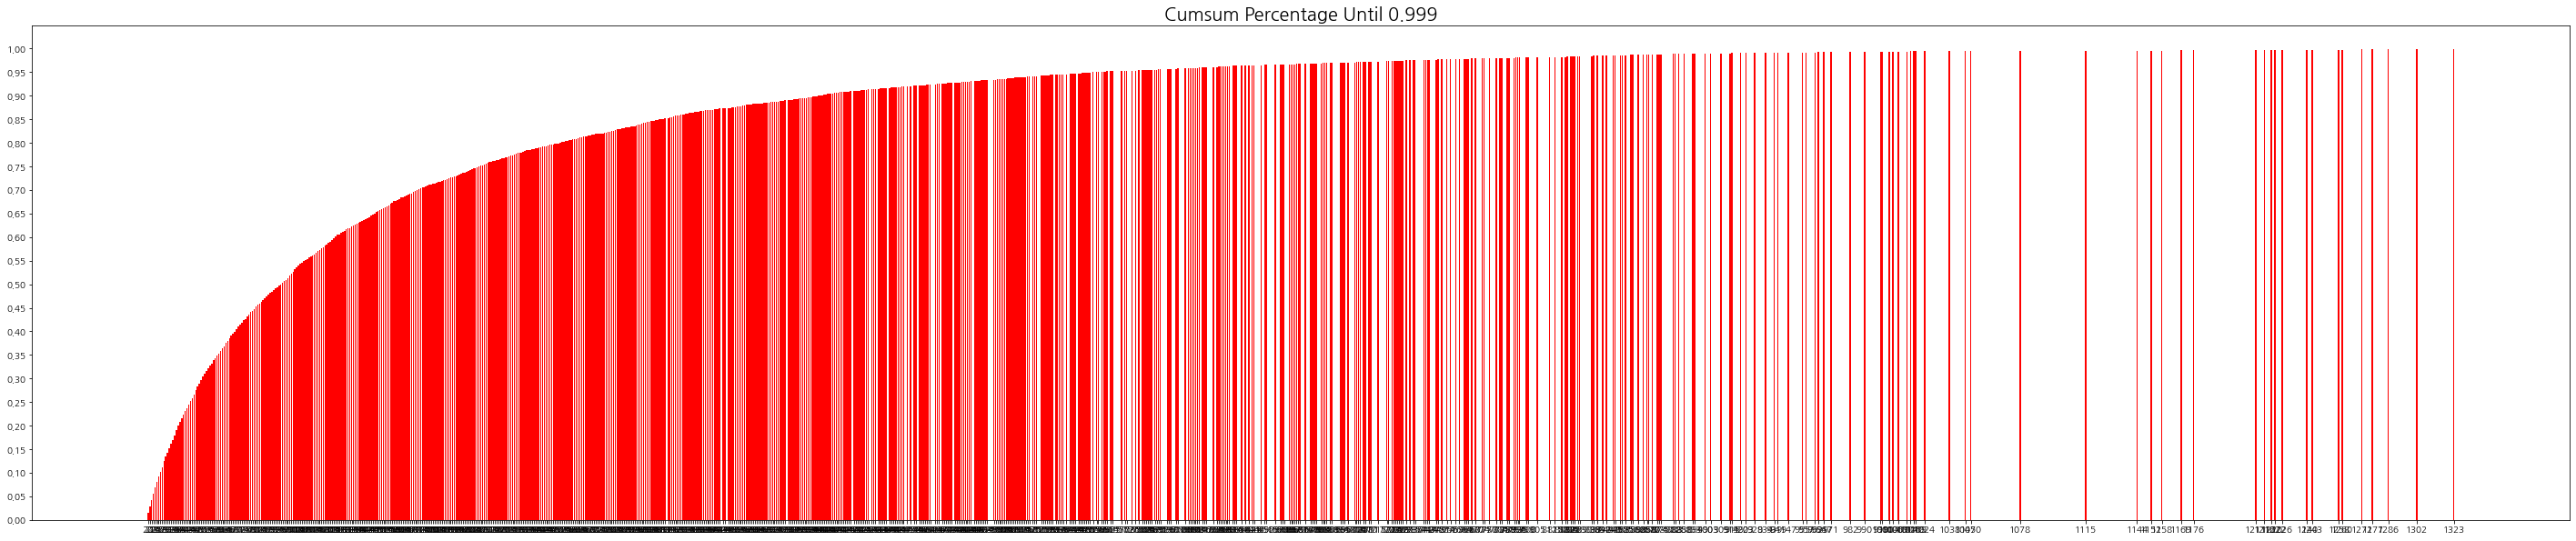

In [12]:
# 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(50, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [13]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-26 08:05:32
2003-03-01 02:49:50


### 데이터 정제하기

In [15]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 100인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [16]:
data = cleanse_recursive(data, shortest=100, least_click=100)
len(data)

775176

## 2. 미니 배치의 구성
- 데이터 분할
- 미니 배치 구성(데이터 로더)

### 데이터 분할

In [17]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [18]:
# train, validation, test split
tr, test = split_by_date(data, n_days=90)
tr, val = split_by_date(tr, n_days=90)

In [19]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [20]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 652084
	 Sessions: 2531
	 Items: 1919
	 First Time : 2000-04-26 08:05:32
	 Last Time : 2002-09-01 05:38:06

* valid Set Stats Info
	 Events: 37915
	 Sessions: 98
	 Items: 1917
	 First Time : 2000-04-28 01:38:08
	 Last Time : 2002-11-30 22:47:32

* test Set Stats Info
	 Events: 85177
	 Sessions: 199
	 Items: 1919
	 First Time : 2000-05-01 20:15:13
	 Last Time : 2003-03-01 02:49:50



In [21]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [22]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### 미니 배치 구성

In [23]:
# dataset 만들기
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [24]:
# 예시
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Time,item_idx
130,2,1198,2001-01-01 06:28:44,0
64,2,1210,2001-01-01 06:29:11,1
71,2,1217,2001-01-01 06:29:11,2
134,2,2717,2001-01-01 06:29:56,3
88,2,1293,2001-01-01 06:31:01,4
170,2,2943,2001-01-01 06:32:52,5
106,2,1225,2001-01-01 06:33:11,6
120,2,1193,2001-01-01 06:33:33,7
172,2,318,2001-01-01 06:33:33,8
70,2,3030,2001-01-01 06:33:54,9


In [25]:
tr_dataset.click_offsets

array([     0,    125,    297, ..., 651653, 651771, 652084], dtype=int32)

In [26]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 2528, 2529, 2530])

In [27]:
# data loader 만들기
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [28]:
# 예시
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Time,item_idx
130,2,1198,2001-01-01 06:28:44,0
64,2,1210,2001-01-01 06:29:11,1
71,2,1217,2001-01-01 06:29:11,2
134,2,2717,2001-01-01 06:29:56,3
88,2,1293,2001-01-01 06:31:01,4
170,2,2943,2001-01-01 06:32:52,5
106,2,1225,2001-01-01 06:33:11,6
120,2,1193,2001-01-01 06:33:33,7
172,2,318,2001-01-01 06:33:33,8
70,2,3030,2001-01-01 06:33:54,9


In [29]:
iter_ex = iter(tr_data_loader)

In [30]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0   3   1 354]
Label Item Idx are :       [  1 125 277 355]
Previous Masked Input Idx are []


## 3. 모델 구성

In [45]:
# 평가 지표
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [33]:
# 모델 구성
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

def create_model_2(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True,return_sequences=True, name='GRU1')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU2')(dropout)
    dropout = Dropout(args.drop_rate)(gru)
    
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [34]:
# 하이퍼 파라미터
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=30, drop_rate=0.1, lr=0.001, epochs=5, k=20)
args1 = Args(tr, val, test, batch_size=64, hsz=60, drop_rate=0.1, lr=0.001, epochs=5, k=20)
args2 = Args(tr, val, test, batch_size=64, hsz=30, drop_rate=0.2, lr=0.001, epochs=5, k=20)
args3 = Args(tr, val, test, batch_size=64, hsz=15, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [35]:
# 모델 만들기
model = create_model(args)
model1 = create_model(args1)
model2 = create_model(args2)
model3 = create_model(args3)

# model_2 = create_model_2(args)
# model1_2 = create_model_2(args1)
# model2_2 = create_model_2(args2)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 1919)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 30), (64, 30)]      175590    
_________________________________________________________________
dropout (Dropout)            (64, 30)                  0         
_________________________________________________________________
dense (Dense)                (64, 1919)                59489     
Total params: 235,079
Trainable params: 235,079
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(64, 1, 1919)]           0         
______________________________________

## 4. 모델 학습
4가지 모델에 대해서 학습한다.

In [36]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.
            #reset_hidden_states_2(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            
            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def reset_hidden_states_2(model, mask):
    gru_layer = model.get_layer(name='GRU1')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)
    
    gru_layer = model.get_layer(name='GRU2')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)
    
    

def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []
    total_step = len(data) - data['UserId'].nunique()
    
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        #reset_hidden_states_2(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [37]:
train_model(model, args)

Train:   0%|          | 0/10149 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.82]

	 - Recall@20 epoch 1: 0.206335
	 - MRR@20    epoch 1: 0.049484



Train:   0%|          | 0/10149 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.19]

	 - Recall@20 epoch 2: 0.275585
	 - MRR@20    epoch 2: 0.071323



Train:   0%|          | 0/10149 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.26]

	 - Recall@20 epoch 3: 0.297772
	 - MRR@20    epoch 3: 0.081503



Train:   0%|          | 0/10149 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.96]

	 - Recall@20 epoch 4: 0.310281
	 - MRR@20    epoch 4: 0.086865



Evaluation:  56%|█████▌    | 331/590 [00:59<00:46,  5.58it/s]

	 - Recall@20 epoch 5: 0.318117
	 - MRR@20    epoch 5: 0.089645



In [38]:
train_model(model1, args1)

Train:   0%|          | 0/10149 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.57]

	 - Recall@20 epoch 1: 0.261518
	 - MRR@20    epoch 1: 0.067171



Train:   0%|          | 0/10149 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.11]

	 - Recall@20 epoch 2: 0.305514
	 - MRR@20    epoch 2: 0.086530



Train:   0%|          | 0/10149 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.98]

	 - Recall@20 epoch 3: 0.320336
	 - MRR@20    epoch 3: 0.092777



Train:   0%|          | 0/10149 [00:00<?, ?it/s, accuracy=0.109, train_loss=4.9]  

	 - Recall@20 epoch 4: 0.327181
	 - MRR@20    epoch 4: 0.096333



Evaluation:  56%|█████▌    | 331/590 [00:58<00:45,  5.65it/s]

	 - Recall@20 epoch 5: 0.328786
	 - MRR@20    epoch 5: 0.097804



In [39]:
train_model(model2, args2)

Train:   0%|          | 0/10149 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.03]

	 - Recall@20 epoch 1: 0.201850
	 - MRR@20    epoch 1: 0.047635



Train:   0%|          | 0/10149 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.4] 

	 - Recall@20 epoch 2: 0.270393
	 - MRR@20    epoch 2: 0.069515



Train:   0%|          | 0/10149 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.16]

	 - Recall@20 epoch 3: 0.294043
	 - MRR@20    epoch 3: 0.078359



Train:   0%|          | 0/10149 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.15]

	 - Recall@20 epoch 4: 0.306883
	 - MRR@20    epoch 4: 0.083974



Evaluation:  56%|█████▌    | 331/590 [00:59<00:46,  5.56it/s]

	 - Recall@20 epoch 5: 0.314199
	 - MRR@20    epoch 5: 0.087720



In [40]:
train_model(model3, args3)

Train:   0%|          | 0/10149 [00:00<?, ?it/s, accuracy=0, train_loss=6.34]     

	 - Recall@20 epoch 1: 0.149783
	 - MRR@20    epoch 1: 0.033622



Train:   0%|          | 0/10149 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.66]

	 - Recall@20 epoch 2: 0.227011
	 - MRR@20    epoch 2: 0.054575



Train:   0%|          | 0/10149 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.54]

	 - Recall@20 epoch 3: 0.261329
	 - MRR@20    epoch 3: 0.063778



Train:   0%|          | 0/10149 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.27]

	 - Recall@20 epoch 4: 0.276482
	 - MRR@20    epoch 4: 0.069774



Evaluation:  56%|█████▌    | 331/590 [00:59<00:46,  5.55it/s]

	 - Recall@20 epoch 5: 0.284318
	 - MRR@20    epoch 5: 0.072810



## 5. 모델 테스트
하이퍼 파라미터를 조정한 4가지 모델에 대해서 테스트한 결과이다.   
첫 번째 모델 기준으로 2번째 모델은 RNN의 길이를 크게 4번째 모델은 RNN의 길이를 작게 하였고 3번째 모델은 dropout 비율을 높였다.   
테스트 결과 RNN layer의 길이가 길수록 더 좋은 성능을 보여주는 것을 알 수 있고,   
dropout의 비율에 차이는 성능에 크게 영향을 미치지 않는 것을 보여준다. (0.1과 0.2의 경우)

In [41]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  80%|████████  | 1067/1327 [03:12<00:46,  5.54it/s]

	 - Recall@20: 0.273372
	 - MRR@20: 0.076550



In [42]:
test_model(model1, args1, test)

Evaluation:  80%|████████  | 1067/1327 [03:10<00:46,  5.59it/s]

	 - Recall@20: 0.287869
	 - MRR@20: 0.085028



In [43]:
test_model(model2, args2, test)

Evaluation:  80%|████████  | 1067/1327 [03:12<00:46,  5.54it/s]

	 - Recall@20: 0.274397
	 - MRR@20: 0.075221



In [44]:
test_model(model3, args3, test)

Evaluation:  80%|████████  | 1067/1327 [03:16<00:47,  5.44it/s]

	 - Recall@20: 0.245929
	 - MRR@20: 0.062230



## 회고 및 루브릭 평가

### 루브릭 평가 항목
1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.(데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.)
2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.(적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.)
3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.(3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.)

### 평가 항목에 대한 수행
1. 데이터 전처리 과정에서 session based recommendation 관점으로 전처리하였다.각각의 유저를 각각의 세션으로 보고 시간의 순서에 따른 데이터로 보고 이를 분석하고 처리하였다.
2. 4가지 모델 모두 5 epoch만큼 학습이 진행되는 동안 train loss가 지속적으로 감소하고, validation에 대하여 성능이 개선하는 것을 볼 수 있다.
3. 4가지 모델에 대해서 하이퍼파라미터를 변경한 실험을 하여 변화 추이를 관찰할 수 있었다.

### 회고

노션에 공지된 꼭 포함이 되어야 할 점
- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**

---
- **어려웠던 점**    
데이터에 대한 설명은 하나도 하지 않고 그냥 데이터만 던져주고 해보라고 해서 어떻게 접근해야 할 지 고민을 좀 했었다. 그리고 직접 만든 평가지표와 데이터셋에 대해서 학습을 시키기 위하여 학습하기 위한 함수를 만들어야 해서 약간 공부를 할 필요가 있었다.

---
- **알아낸 점**    
이번에 노드를 보고 @k 개념에 대해서 알 수 있었다. 그리고 추천시스템에서 session을 이용한 방법도 연구가 되고 있다는 것을 알 수 있었다.

- **모호한 점**    
Session 정보를 이용하는 아이디어는 좋은 것 같은데 실제로 좋은 성능을 보여주는 지는 의문이 많이 든다.

---
- **시도한 것들**   
하이퍼파라미터를 변경하여 4가지 모델에 대해서 시도를 하였다.(위에 코드에서는 나타나지 않지만 전처리 과정에서 데이터 정제하는 방법들과 모델 구성을 바꾸는 시도 등을 하였다.

---
- **우브릭 평가 관련 지표**   
제 예상에는 모두 달성되었다고 생각한다. 그 이유는 위에 있는 **평가 항목에 대한 수행**에 나와있다.  
- **자기 다짐** 및 **나의 생각들**      
프로젝트 내용은 session based recommendation이다. Session 정보를 이용하기 때문에 시간에 따른 데이터로써 시계열 데이터 처리하는 것처럼 할 수 있다. 그래서 여기서는 RNN을 이용하여 모델을 구성하였다. 솔직히 이번 프로젝트는 학습에 도움이 되지 않은 것 같다. 결국 session based recommendation은 추천시스템을 구성할 때 시계열 데이터를 이용하는 것이 아이디어 이기 때문에 시계열 데이터를 처리하는 것에 불과하기 때문이다. 추천시스템이라고 시계열 데이터와 다른 특별한 것들을 해준 것이 아니기 때문에 필요 없는 노드라고 생각한다. 차라리 시계열 노드나 추천시스템 노드에 이런 적용이나 방법들이 있다고 소개하는 것으로도 충분할 것 같다.   
그리고 노드를 할 때 오히려 데이터를 분석하는 방법에 대해서 많이 소개를 해주면 좋을 것 같다. 실제 프로젝트를 하면 모델 구성하고 실험하는 것보다 사람이 직접해야 할 것은 데이터를 이해하고 분석하는 것인데 내 기준으로 이에 대해서 자세히 소개를 해준 노드가 없었다. 이 점이 많이 아쉬운 것 같다.